In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import sc2ts
import tszip

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import adjustText
from PIL import Image

import nb_utils
from nb_utils import DATA_DIR

png_dir = Path("../figures/static")

recomb_df = pd.read_csv(DATA_DIR / "recombinants.csv").set_index("sample_id")


In [2]:
# Add CovRecomb data
df = pd.read_csv("../arg_postprocessing/sc2ts_v1_2023-02-21_pr_pp_mp_aph_bps_pango_dated_CovRecomb_output.csv")
df = df.set_index("sample_id")

recomb_df["is_cov_recomb_recombinant"] = {sample_id: sample_id in df.index for sample_id in recomb_df.index}

In [3]:
df = pd.read_csv("../arg_postprocessing/sc2ts_v1_2023-02-21_pr_pp_mp_aph_bps_pango_dated_3seq.csv")
# Just getting yes/no answer for now
recombinants = df["recombinant"].unique()
recomb_df["is_3seq_recombinant"] = {k: row["recombinant"] in recombinants for k, row in recomb_df.iterrows()}


In [4]:
df_robust = recomb_df[recomb_df.net_min_supporting_loci_lft_rgt_ge_4].copy()
print(f"Using {len(df_robust)} recombinants passing QC")

Using 354 recombinants passing QC


In [5]:
df_robust['num_mutations_averted'] = df_robust.k1000_muts - df_robust.num_mutations
df_robust['tmrca'] = df_robust.parent_mrca_time - df_robust.recombinant_time 

In [6]:
ts = tszip.load(DATA_DIR / "sc2ts_viridian_v1.2.trees.tsz")
re_labels = nb_utils.standard_recombinant_labels(ts, DATA_DIR / "pango_x_events.csv")

## Analysis of strongly supported recombinants

Of the 38 recombinants that are strongly supported (at least 10 averted mutations), 29 are novel. The known recombinants are XA, XC, XS, XBR, and all of the Jackson et al recombinants. All but 2 of the 38 are classified as recombinant by rebar. 


In [7]:
known_recombs = {k: v for k, v in re_labels.items() if v != "XBB.x"}
df_robust["label"] = df_robust["recombinant"].map(lambda u: known_recombs.get(u, "novel"))

In [8]:
strong_support_cutoff = 10

In [9]:
df_strong_evidence = df_robust[df_robust["num_mutations_averted"] >= strong_support_cutoff].copy()
df_strong_evidence[["label", "recombinant", "num_descendant_samples", "is_rebar_recombinant"]]

,label,recombinant,num_descendant_samples,is_rebar_recombinant
sample_id,,,,
SRR19814523,novel,967112,1,True
SRR15856342,novel,465910,1,True
SRR17428451,novel,875387,5,True
SRR17647498,novel,897177,1,True
SRR15489508,novel,376921,2,True
SRR20358773,novel,1057084,1,True
SRR19817338,XS,1000242,17,True
ERR5238288,J3,104754,1,True
ERR8686127,novel,1048126,1,True


In [10]:
df_strong_evidence.shape[0]

38

In [11]:
df_strong_evidence["label"].value_counts()

label
novel     29
XS         1
J3         1
J1         1
XA(JA)     1
XBR        1
JD         1
XC         1
J2         1
JC         1
Name: count, dtype: int64

In [12]:
df_strong_evidence["is_rebar_recombinant"].value_counts()

is_rebar_recombinant
True     36
False     2
Name: count, dtype: int64

In [13]:
df_strong_evidence[~df_strong_evidence["is_rebar_recombinant"]][["label"]]

,label
sample_id,
SRR19291479,novel
SRR16729550,novel


In [14]:
df_strong_evidence[df_strong_evidence["label"] == "novel"]["num_descendant_samples"].value_counts()

num_descendant_samples
1    20
2     4
3     2
4     2
5     1
Name: count, dtype: int64

## Analysis of the remainder

In [15]:
df_rest = df_robust[df_robust["num_mutations_averted"] < strong_support_cutoff].copy()
df_rest.shape[0]

316

In [16]:
df_rest["label"].value_counts()

label
novel    298
XW         1
XQ         1
XF         1
XG         1
JB         1
XL         1
XBF        1
XAF        1
XE/XH      1
XY         1
XJ         1
XM         1
XBH        1
XBB        1
XBM        1
XBG        1
XBD        1
Xx         1
Name: count, dtype: int64

In [17]:
df_rest[df_rest["label"] == "novel"]["is_rebar_recombinant"].value_counts()

is_rebar_recombinant
True     151
False    147
Name: count, dtype: int64

## RIPPLES headline number

Abstract: "In a 1.6 million sample tree from May 2021, we identify 589 recombination events"

> To mitigate the impacts of sequencing and assembly errors, we exclude all nodes with only a single descendant, we applied conservative filters to remove potentially spurious samples from the recombinant sets flagged by RIPPLES, and we manually confirmed mutations in a subset of putative recombinant samples using raw sequence read data (Supplementary Texts 7 and 8, Extended Data Table 2 and Extended Data Fig. 3). After this, we retained 589 unique recombination events, which have a combined total of 43,104 descendant samples (Supplementary Table 1). This means that around 2.7% of total sampled SARS-CoV-2 genomes are inferred to belong to detectable recombinant lineages. 


In [18]:
date_threshold = "2021-06";
df_ripples_paper = recomb_df[recomb_df["date_added"] < date_threshold]
df_ripples_paper.shape

(40, 54)

In [19]:
df_ripples_paper_hq = df_ripples_paper[df_ripples_paper["net_min_supporting_loci_lft_rgt_ge_4"]]

In [20]:
df_ripples_paper_hq.shape

(27, 54)

We must also filter out the singletons

In [21]:
df = df_ripples_paper_hq[df_ripples_paper_hq["num_descendant_samples"] > 1]
df

,recombinant,num_descendant_samples,num_samples,distinct_sample_pango,interval_left,interval_right,num_mutations,Viridian_amplicon_scheme,Artic_primer_version,date_added,...,net_min_supporting_loci_rgt,net_min_supporting_loci_lft_rgt_ge_4,k1000_muts,event_label,ripples_p4,ripples_p3,is_ripples_p4_recombinant,is_ripples_p3_recombinant,is_cov_recomb_recombinant,is_3seq_recombinant
sample_id,,,,,,,,,,,,,,,,,,,,,
ERR5403161,130133,2,2,1,4891,6286,3,COVID-ARTIC-V3,3,2021-02-06,...,20,True,11,novel,True,True,True,True,True,True
ERR5058070,82697,2,1,1,6529,6954,0,COVID-ARTIC-V3,3,2020-12-23,...,38,True,6,novel,True,True,True,True,False,True
SRR21719160,28379,3,1,1,6542,9515,0,COVID-ARTIC-V3,.,2020-09-02,...,19,True,4,novel,False,False,False,False,False,True
SRR15151196,254203,3,1,1,9868,11312,1,COVID-ARTIC-V3,.,2021-05-01,...,35,True,15,novel,True,True,True,True,True,True
SRR15226187,277217,3,2,1,12163,13887,0,COVID-AMPLISEQ-V1,.,2021-05-28,...,13,True,5,novel,True,True,True,True,False,True
SRR16729550,260179,4,1,1,21659,21707,2,COVID-ARTIC-V3,.,2021-05-07,...,11,True,13,novel,True,True,True,True,False,True
ERR5308556,122444,39,1,1,20411,21765,0,COVID-ARTIC-V3,3,2021-01-30,...,26,True,16,XA,True,True,True,True,True,True
ERR4615866,26465,54,1,1,15325,21855,1,COVID-ARTIC-V3,3,2020-08-24,...,10,True,6,novel,False,True,False,True,False,True
ERR5335088,125722,3,2,1,22445,23063,3,COVID-ARTIC-V3,3,2021-02-02,...,20,True,21,novel,True,True,True,True,True,True


In [22]:
df["num_descendant_samples"].sum()

np.int64(172)

In [23]:
recombinant_descendants = df["num_descendant_samples"].sum()

In [24]:
# Get the number of samples
dfn = sc2ts.node_data(ts, inheritance_stats=False)
df_sample = dfn[dfn.is_sample]

In [25]:
total_samples = (df_sample["date"] < date_threshold).sum()
total_samples

np.int64(501235)

In [26]:
(recombinant_descendants / total_samples) * 100

np.float64(0.034315241353855976)

In [27]:
2.7 / 0.034315241353855976

78.68223837209302

In [28]:
589 / 14

42.07142857142857

## CovRecomb results

Of the 92 recombinants found by CovRecomb, only 2 fail the sc2ts QC filter.

In [29]:
df = pd.read_csv("../arg_postprocessing/sc2ts_v1_2023-02-21_pr_pp_mp_aph_bps_pango_dated_CovRecomb_output.csv")
df = df.set_index("sample_id")
df.shape

(92, 9)

In [30]:
df_cr = recomb_df.loc[df.index]
df_cr["net_min_supporting_loci_lft_rgt_ge_4"].value_counts()

net_min_supporting_loci_lft_rgt_ge_4
True     90
False     2
Name: count, dtype: int64

In [31]:
df_robust

,recombinant,num_descendant_samples,num_samples,distinct_sample_pango,interval_left,interval_right,num_mutations,Viridian_amplicon_scheme,Artic_primer_version,date_added,...,event_label,ripples_p4,ripples_p3,is_ripples_p4_recombinant,is_ripples_p3_recombinant,is_cov_recomb_recombinant,is_3seq_recombinant,num_mutations_averted,tmrca,label
sample_id,,,,,,,,,,,,,,,,,,,,,
ERR9380041,1145912,1,1,1,2833,3542,0,COVID-ARTIC-V4.1,4.1alt,2022-03-15,...,novel,False,True,False,True,False,True,5,607.076646,novel
ERR7480952,752005,2,2,1,3402,4100,2,COVID-ARTIC-V4.1,4,2021-11-11,...,novel,True,True,True,True,False,True,5,314.261057,novel
SRR15776056,417645,1,1,1,1878,4181,1,COVID-ARTIC-V3,.,2021-08-14,...,novel,True,True,True,True,False,True,4,366.287717,novel
SRR20186337,854204,2,1,1,3123,4181,3,COVID-AMPLISEQ-V1,.,2021-12-04,...,novel,True,True,True,True,False,True,4,484.692878,novel
ERR9444530,1159411,32,1,1,2833,4321,1,COVID-ARTIC-V4.1,4.1alt,2022-03-20,...,XW,False,True,False,True,False,True,4,621.741220,XW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR22484659,1406252,2,1,1,27439,28312,2,COVID-ARTIC-V4.1,.,2022-11-07,...,novel,False,False,False,False,False,True,4,220.082143,novel
SRR21636269,1360479,1,1,1,27439,28330,0,COVID-ARTIC-V4.1,.,2022-09-04,...,novel,True,True,True,True,False,True,5,177.924499,novel
SRR21139593,1274474,21,1,1,27439,28330,0,COVID-ARTIC-V4.1,.,2022-06-20,...,novel,False,False,False,False,False,True,4,74.888546,novel


In [32]:
np.sum(df_robust["is_rebar_recombinant"])

np.int64(203)

In [33]:
np.sum(df_robust["is_cov_recomb_recombinant"])

np.int64(90)

In [34]:
len(set(df_robust[df_robust["is_rebar_recombinant"]].index) & set(df_robust[df_robust["is_cov_recomb_recombinant"]].index))

84

In [35]:
df_not_p3 = df_robust[~df_robust["ripples_p3"]]
df_not_p3

,recombinant,num_descendant_samples,num_samples,distinct_sample_pango,interval_left,interval_right,num_mutations,Viridian_amplicon_scheme,Artic_primer_version,date_added,...,event_label,ripples_p4,ripples_p3,is_ripples_p4_recombinant,is_ripples_p3_recombinant,is_cov_recomb_recombinant,is_3seq_recombinant,num_mutations_averted,tmrca,label
sample_id,,,,,,,,,,,,,,,,,,,,,
ERR8495032,995727,5,1,1,4185,4321,0,COVID-ARTIC-V4.1,4.1alt,2022-01-27,...,novel,False,False,False,False,False,True,6,579.041636,novel
ERR8691075,1058654,154,1,1,4322,5386,0,COVID-ARTIC-V4.1,4.1alt,2022-02-12,...,XQ,False,False,False,False,False,True,7,589.041636,XQ
SRR20392523,1057278,1,1,1,5585,6040,2,COVID-ARTIC-V4.1,.,2022-02-11,...,novel,False,False,False,False,False,True,6,731.737976,novel
ERR8076129,946761,16,1,1,5387,6402,1,COVID-ARTIC-V4.1,4.1alt,2022-01-13,...,XF,False,False,False,False,False,True,5,713.059657,XF
ERR6457057,369130,1,1,1,5585,6402,1,COVID-ARTIC-V3,3,2021-07-29,...,novel,False,False,False,False,False,True,5,358.953600,novel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR21382433,1341416,1,1,1,27039,27259,2,COVID-ARTIC-V4.1,.,2022-08-15,...,novel,False,False,False,False,True,True,5,131.747327,novel
ERR10666854,1411996,1,1,1,23278,27438,2,COVID-ARTIC-V4.1,4.1alt,2022-11-29,...,novel,False,False,False,False,False,True,4,268.773310,novel
SRR21909427,1385832,2,1,1,27439,27998,0,COVID-ARTIC-V4.1,.,2022-10-03,...,novel,False,False,False,False,False,True,5,156.570839,novel


In [36]:
df_not_p3["is_cov_recomb_recombinant"].value_counts()

is_cov_recomb_recombinant
False    58
True     18
Name: count, dtype: int64

In [37]:
df_not_p3["is_rebar_recombinant"].value_counts()

is_rebar_recombinant
True     46
False    30
Name: count, dtype: int64

In [38]:
df_robust.ripples_p3.sum()

np.int64(278)

In [39]:
df_robust.ripples_p4.sum()

np.int64(221)

In [40]:
np.sum(df_robust["is_rebar_recombinant"])

np.int64(203)

In [41]:
np.sum(df_robust["is_cov_recomb_recombinant"])

np.int64(90)

In [42]:
recomb_df["is_rebar_recombinant"].value_counts()

is_rebar_recombinant
False    642
True     213
Name: count, dtype: int64

In [43]:
df_robust["is_rebar_recombinant"].value_counts()

is_rebar_recombinant
True     203
False    151
Name: count, dtype: int64

## 3SEQ results

In [44]:
df = pd.read_csv("../arg_postprocessing/sc2ts_v1_2023-02-21_pr_pp_mp_aph_bps_pango_dated_3seq.csv")
df

,P_name,Q_name,C_name,m,n,k,p,HS?,log10(p),DS(p),DS(p).1,min_rec_length,breakpoints,recombinant
0,484484,588497,663484,4,16,16,1.031992e-03,0,-2.9863,0.00206,2.062919e-03,509,509-2830 & 28300-29903,663484
1,1253363,1189178,1279026,7,8,8,1.243201e-03,0,-2.9055,0.00248,2.484857e-03,694,694-5824 & 28331-29903,1279026
2,397795,424293,440320,4,37,37,4.937297e-05,0,-4.3065,0.00010,9.874350e-05,518,518-2163 & 28917-29903,440320
3,1024501,1024834,1028159,4,11,11,3.663004e-03,0,-2.4362,0.00731,7.312590e-03,518,518-6277 & 27514-29903,1028159
4,856984,955855,982641,80,6,6,1.722840e-07,0,-6.7638,0.00000,3.445670e-07,8,210-685 & 693-2667,982641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,1054868,1341987,1375056,4,23,23,2.849003e-04,0,-3.5453,0.00057,5.697195e-04,175,0-3925 & 25158-29728,1375056
480,1054868,1363421,1373412,5,26,26,3.531261e-05,0,-4.4521,0.00007,7.062397e-05,175,0-1625 & 28088-29728,1373412
481,1054868,1335901,1418709,5,24,24,5.052420e-05,0,-4.2965,0.00010,1.010458e-04,175,0-2952 & 28313-29728,1418709
482,1054868,1411836,1436032,4,29,29,1.221897e-04,0,-3.9130,0.00024,2.443644e-04,175,0-403 & 26276-29728,1436032


In [45]:
recombinants = df["recombinant"].unique()
recombinants.shape

(484,)

In [46]:
recomb_df[recomb_df["is_3seq_recombinant"]]["net_min_supporting_loci_lft_rgt_ge_4"].value_counts()

net_min_supporting_loci_lft_rgt_ge_4
True     338
False    146
Name: count, dtype: int64

In [47]:
df_robust.shape

(354, 57)

## Generate figures

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


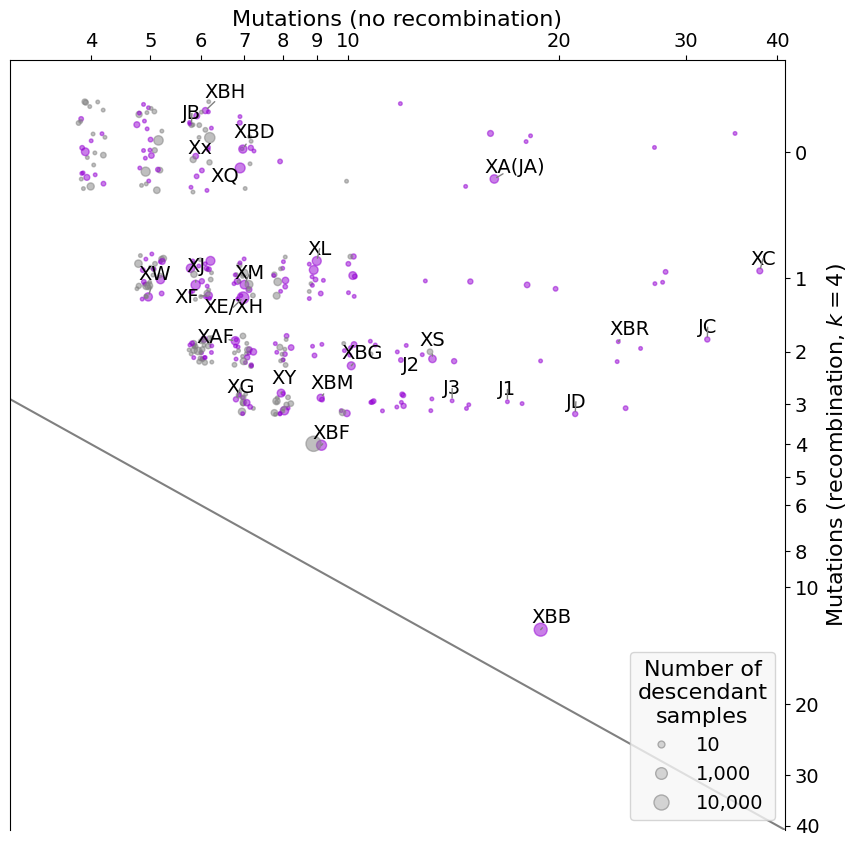

In [48]:

def draw_averted_scatterplot(df, classifier_col, ax, 
                             jitter_seed=2, jitter_width=0.25, legend_loc="lower right"):
    def pointscale(num_descendant_samples):
        return 10 * (np.log(num_descendant_samples + 1))

    np.random.seed(jitter_seed)
    j1 = np.random.uniform(-jitter_width, jitter_width, len(df))
    j2 = np.random.uniform(-jitter_width, jitter_width, len(df))

    colorpal = ["gray", "darkviolet"]
    patches = [
        mpatches.Patch(color=colorpal[0], label="Non-recombinant"),
        mpatches.Patch(color=colorpal[1], label="Recombinant"),
    ]

    x = df.k1000_muts
    y = df.num_mutations  # for k == 4
        
    ax.scatter(
        (1 + x) + j1,
        (1 + y) + j2,
        alpha=0.5,
        s=pointscale(df.num_descendant_samples),
        c=[colorpal[int(x)] for x in df[classifier_col]],
        edgecolors=None,
    )
    ax.set_xlabel("Mutations (no recombination)", fontsize=16)
    ax.set_ylabel("Mutations (recombination, $k=4$)", fontsize=16)

    legend_elements = [
        Line2D([0], [0], marker='o', color='none', markerfacecolor='lightgrey', markeredgecolor="darkgrey",
               markersize=np.sqrt(pointscale(10)), label='10'),
        Line2D([0], [0], marker='o', color='none', markerfacecolor='lightgrey', markeredgecolor="darkgrey",
               markersize=np.sqrt(pointscale(1000)), label='1,000'),
        Line2D([0], [0], marker='o', color='none', markerfacecolor='lightgrey', markeredgecolor="darkgrey",
               markersize=np.sqrt(pointscale(100000)), label='10,000')
    ]

    leg = ax.legend(
        handles=legend_elements,
        title="Number of\ndescendant\nsamples",
        fontsize=14,
        title_fontsize=16,
        loc=legend_loc,
        frameon=True,
        facecolor='0.97',
    )
    leg.get_title().set_multialignment('center')

    texts = []
    for i, (xx, yy, row) in enumerate(zip(x, y, df.itertuples())):
        label = re_labels.get(row.recombinant)
        if label is not None:
            texts.append(ax.text((1 + xx) + j1[i], (1 + yy) + j2[i], label, fontsize=14, ha="right"))

    ax.plot([0.1, 10, 100], [0.1, 10, 100], c="gray")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(3.9, 42)
    ax.set_ylim(0.6, 42)
    #ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('right')
    ax.invert_yaxis()
    ax.minorticks_off()
    xticks = [5, 6, 7, 8, 9, 10, 11, 21, 31, 41]
    yticks = [1, 2, 3, 4, 5, 6, 7, 9, 11, 21, 31, 41]
    ax.set_xticks(ticks = xticks, labels = [t - 1 for t in xticks], fontsize=14)
    ax.set_yticks(ticks = yticks, labels = [t - 1 for t in yticks], fontsize=14)
    ax.tick_params(
        axis='x',   # Apply changes to the x-axis
        top=True, # Show ticks on the top side
        labeltop=True,    # Show tick labels on the top side
        bottom=False, # Hide ticks on the bottom side
        labelbottom=False,    # Hide tick labels on the bottom side
    )
    ax.tick_params(
        axis='y',   # Apply changes to the y-axis
        right=True, # Show ticks on the right side
        labelright=True,    # Show tick labels on the right side
        left=False, # Hide ticks on the left side
        labelleft=False,    # Hide tick labels on the left side
    )

    adjustText.adjust_text(
        texts,
        arrowprops=dict(
            relpos=(0.5, 0.0),
            arrowstyle="-",
            color="gray",
            shrinkA=10,
            lw=1,
        ),
        ax=ax,
    )

# Check it looks OK
_, ax = plt.subplots(1, 1, figsize=(10, 10))
draw_averted_scatterplot(df_robust, "is_rebar_recombinant", ax);

In [54]:

# Define RE nodes for which to show a copying pattern
copying_images = {"XA(JA)": {}, "XBB": {}, "XW": {}}

# This loop takes a little time to do the HTML copying pattern table -> PNG conversion
try:
    for label, val in copying_images.items():
        label = label.replace("XW", "XW")
        label = label.replace("XBB.x", "XBB.1")
        label = label.replace("XA(JA)", "XA")
        val['img'] = np.asarray(Image.open(png_dir / (label + ".png")))
except FileNotFoundError:
    print("You need to run the src/save_pangoX_copying_patterns.py script to generate copying patterns")
    raise

In [55]:
def draw_copying_patterns(copying_images, ax, y_scale):
    row_pos = [0.3, -0.1, -0.4]
    copying_images["XA(JA)"]["pos"] = [0, row_pos[0]]
    copying_images["XW"]["pos"] = [0, row_pos[1]]
    copying_images["XBB"]["pos"] = [0, row_pos[2]]   # Manually adjusted
    #copying_images["XBB.x"]["pos"] = [0.40, row_pos[2]]

    ax.axis("off")
    for label, val in copying_images.items():
        img = val["img"]
        img_height, img_width = img.shape[:2]  # Get height and width
        aspect_ratio = img_width / img_height
        box = val["pos"] + [y_scale * aspect_ratio, 1]
        ax_image = ax.inset_axes(box)
        ax_image.imshow(val["img"], aspect="equal")
        ax_image.axis('off')  # Remove axis of the image
        ax_image.text(-6, 30, label, fontsize=15, ha="right")


In [56]:
def draw_stacked_histogram(
    ax,
    a,
    b,
    *,
    alegend,
    blegend,
    acolor,
    bcolor,
    xlabel,
    ylabel,
    xlim,
    bin_size,
    bar_width=0.8,
    show_legend=True,
    method_label=None,
    show_top_spline=True,
    show_right_spline=True,
    legend_loc=None,
):
    bin_edges = np.arange(xlim[0], xlim[1], bin_size)
    hist_a, _ = np.histogram(a, bins=bin_edges)
    hist_b, _ = np.histogram(b, bins=bin_edges)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 - 0.5
    _ = ax.bar(
        bin_centers,
        hist_a,
        width=bar_width,
        label=alegend,
        color=acolor,
    )
    _ = ax.bar(
        bin_centers,
        hist_b,
        bottom=hist_a,
        width=bar_width,
        label=blegend,
        color=bcolor,
    )
    ax.set_xticks(bin_centers.astype(int))
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    if not show_top_spline:
        ax.spines['top'].set_visible(False)
    if not show_right_spline:
        ax.spines['right'].set_visible(False)
    if show_legend:
        ax.legend(
            fontsize=14,
            loc=legend_loc,
            title_fontsize=16,
            title=method_label,
            frameon=True,
            facecolor='0.97',
        )


In [59]:


def draw_recombinants_figure(col, method_label, show_copying_patterns=False):
        
    rebar_nr_averted_muts = df_robust[~df_robust[col]].num_mutations_averted
    rebar_re_averted_muts = df_robust[df_robust[col]].num_mutations_averted
    
    rebar_nr_tmrca = df_robust[~df_robust[col]].tmrca
    rebar_re_tmrca = df_robust[df_robust[col]].tmrca
    
    rebar_nr_pango_dist = df_robust[~df_robust[col]].parent_pangonet_distance
    rebar_re_pango_dist = df_robust[df_robust[col]].parent_pangonet_distance

    colorpal = ["gray", "darkviolet"]

    agreement = 100* df_robust[col].sum() / df_robust.shape[0] 
    method_label += f"\n({agreement:.0f}% agreement)"
    
    if show_copying_patterns:
        fig = plt.figure(figsize=(18, 12))
        gs = GridSpec(3, 2, figure=fig, wspace=0.4, width_ratios=(2, 1))
    else:
        fig = plt.figure(figsize=(18, 8))
        gs = GridSpec(2, 2, figure=fig, wspace=0.4, width_ratios=(2, 1))
    
    scatter_ax = fig.add_subplot(gs[0:2, 0])
    inset_hist_averted_muts_ax = scatter_ax.inset_axes([0, 0, 1.0, 0.5])
    inset_hist_averted_muts_ax.set_facecolor("none")
    hist_tmrca_ax = fig.add_subplot(gs[0, 1])
    hist_pango_dist_ax = fig.add_subplot(gs[1, 1])
    
    draw_averted_scatterplot(df_robust, col, scatter_ax, jitter_seed=2, legend_loc=(0.8, 0.2))
   
    
    draw_stacked_histogram(
        ax=inset_hist_averted_muts_ax,
        method_label=method_label,
        a=rebar_re_averted_muts,
        b=rebar_nr_averted_muts,
        alegend='Recombinant',
        blegend='Non-recombinant',
        acolor=colorpal[1],
        bcolor=colorpal[0],
        ylabel='Recombination nodes',
        xlabel='Mutations averted by recombination',
        xlim=[4, 25],
        bin_size=1,
        show_legend=True,
        show_top_spline=False,
        show_right_spline=False,
        legend_loc=(0.32, 0.09),
    )
    inset_hist_averted_muts_ax.tick_params(axis='both', which='major', labelsize=14)
    
    draw_stacked_histogram(
        ax=hist_tmrca_ax,
        a=rebar_re_tmrca,
        b=rebar_nr_tmrca,
        alegend='Recombinant',
        blegend='Non-recombinant',
        acolor=colorpal[1],
        bcolor=colorpal[0],
        ylabel='Recombination nodes',
        xlabel='Time to the MRCA of sc2ts parents',
        xlim=[0, 800],
        bin_size=25,
        bar_width=25,
        show_legend=False,
    )
    hist_tmrca_ax.tick_params(axis='both', which='major', labelsize=14)
    xticks = [x for x in range(0, 900, 100)]
    hist_tmrca_ax.set_xticks(ticks=xticks, labels=xticks, fontsize=14)
    
    draw_stacked_histogram(
        ax=hist_pango_dist_ax,
        a=rebar_re_pango_dist,
        b=rebar_nr_pango_dist,
        alegend='Recombinant',
        blegend='Non-recombinant',
        acolor=colorpal[1],
        bcolor=colorpal[0],
        ylabel='Recombination nodes',
        xlabel='Pango distance between sc2ts parents',
        xlim=[0, 20],
        bin_size=1,
        show_legend=False,
    )
    hist_pango_dist_ax.tick_params(axis='both', which='major', labelsize=14)
    xticks = [x for x in range(10)] + [int(max(df_robust.parent_pangonet_distance))]
    hist_pango_dist_ax.set_xticks(ticks=xticks, labels=xticks, fontsize=14)
    
    scatter_ax.text(37, 0.8, "A", size=30)
    hist_tmrca_ax.text(725, 34, "B", size=30)
    hist_pango_dist_ax.text(17.1, 85, "C", size=30)
    if show_copying_patterns:
        copypattern_ax = fig.add_subplot(gs[2, :])
        draw_copying_patterns(copying_images, copypattern_ax, y_scale=0.038)
        copypattern_ax.text(0.97, 0.75, "D", size=30, zorder=10)
        copypattern_lineheight = 0.055
        copypattern_txt_x = 0.79
        x = 0.64
        copypattern_ax.text(x, copypattern_txt_x + copypattern_lineheight, "} Left parent", size=11, zorder=10)
        copypattern_ax.text(x, copypattern_txt_x, "} Recombinant", size=11, zorder=10)
        copypattern_ax.text(x, copypattern_txt_x - copypattern_lineheight, "} Right parent", size=11, zorder=10)
        copypattern_ax.text(0.68 / 2, copypattern_txt_x - 3 * copypattern_lineheight, 
                            "Genomic sites at which parents differ (red/orange = adjacent)", size=11, zorder=10, ha="center")



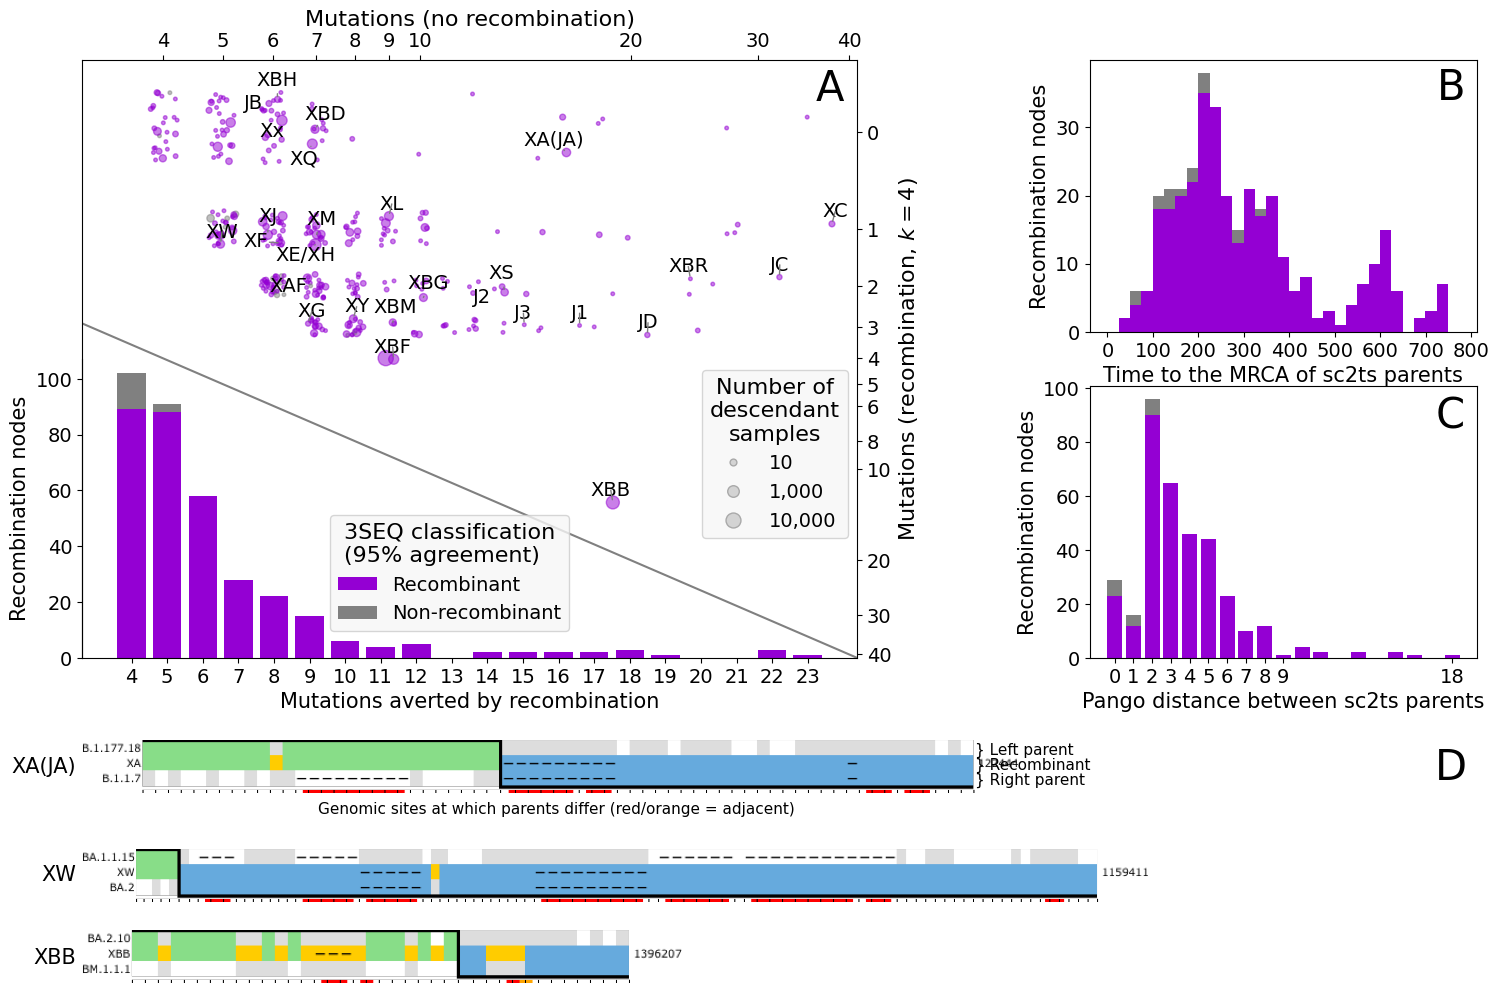

In [60]:
draw_recombinants_figure("is_3seq_recombinant", "3SEQ classification",
                        show_copying_patterns=True)
plt.savefig("../figures/recombinant_evidence.pdf", bbox_inches="tight");

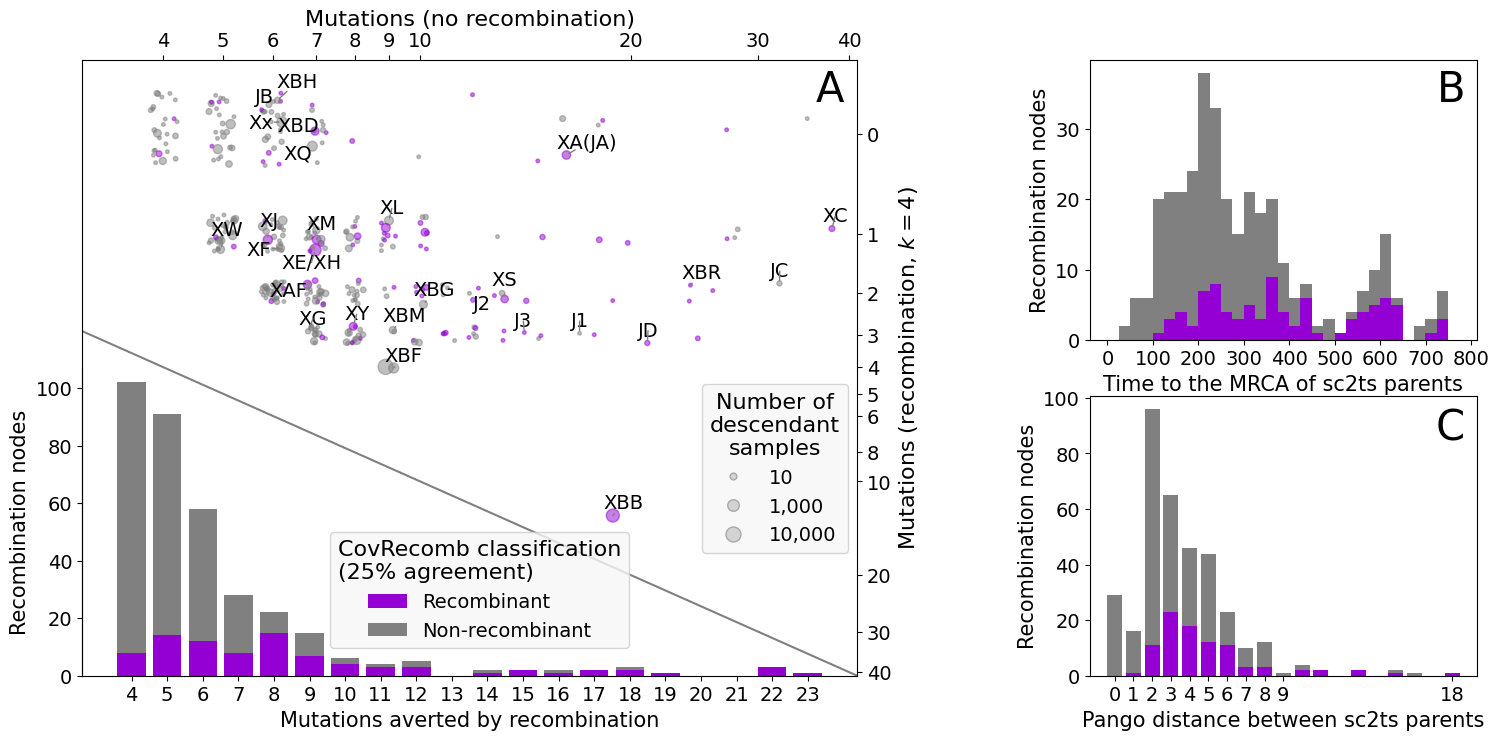

In [61]:
draw_recombinants_figure("is_cov_recomb_recombinant", "CovRecomb classification")
plt.savefig("../figures/recombinant_evidence_cov_recomb.pdf", bbox_inches="tight");

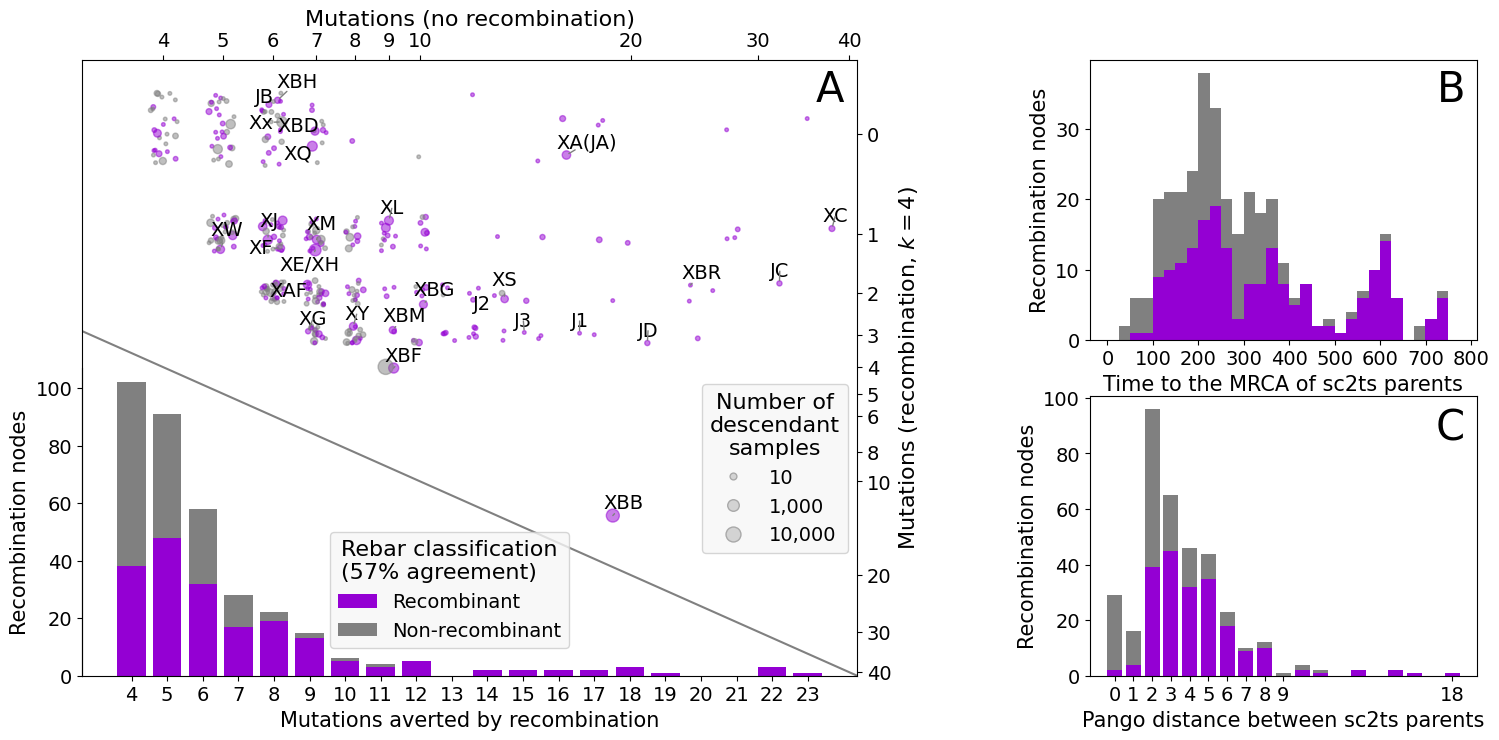

In [62]:
draw_recombinants_figure("is_rebar_recombinant", "Rebar classification")
plt.savefig("../figures/recombinant_evidence_rebar.pdf", bbox_inches="tight");

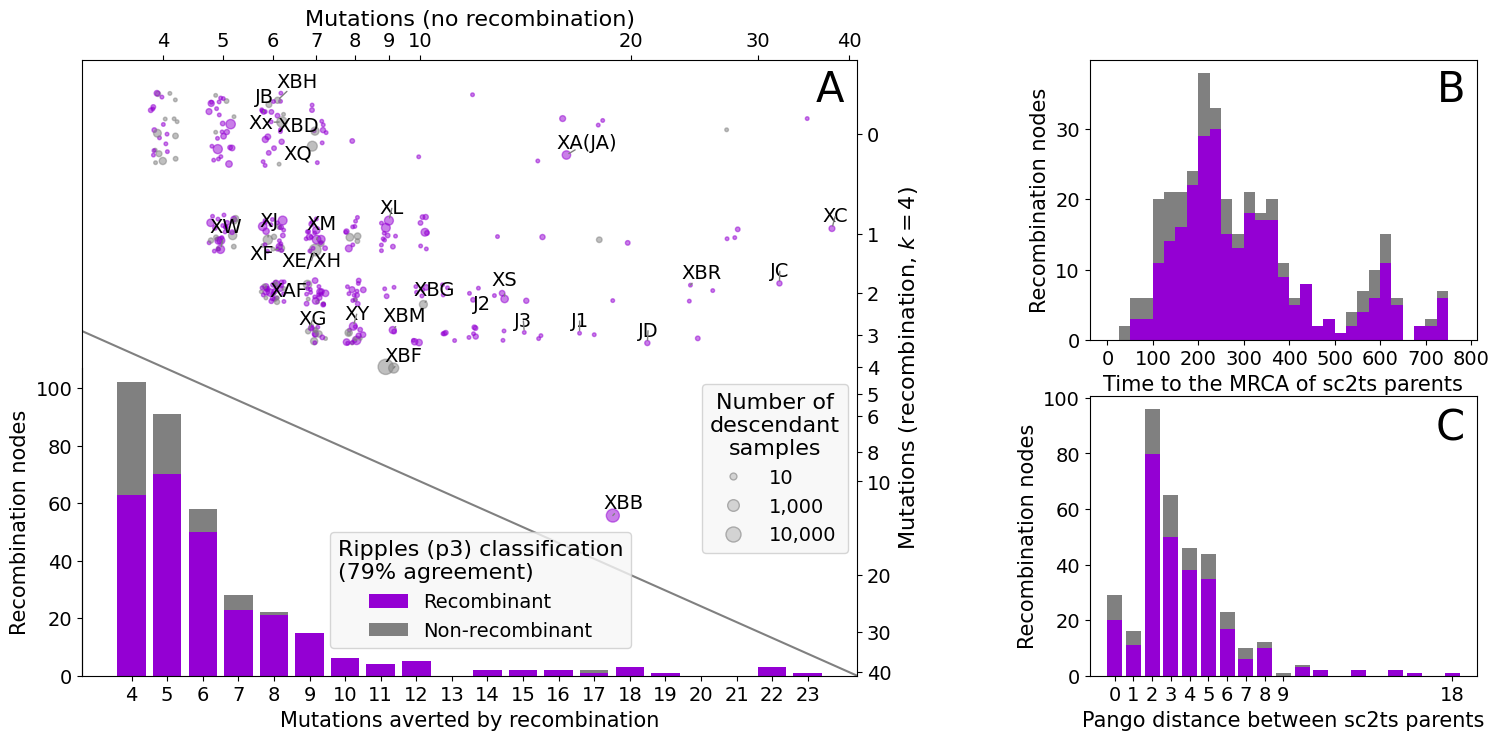

In [63]:
draw_recombinants_figure("is_ripples_p3_recombinant", "Ripples (p3) classification")
plt.savefig("../figures/recombinant_evidence_ripples_p3.pdf", bbox_inches="tight");

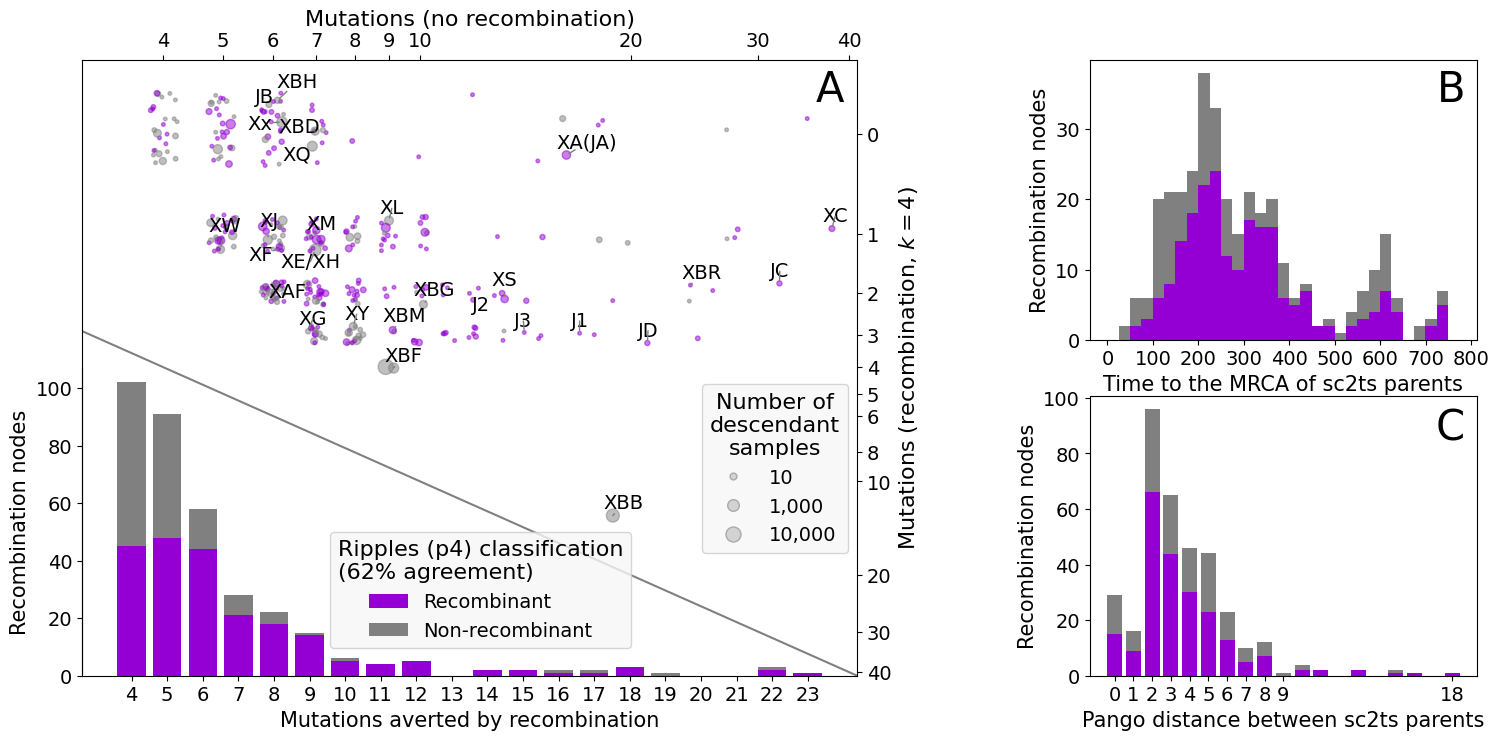

In [64]:
draw_recombinants_figure("is_ripples_p4_recombinant", "Ripples (p4) classification")
plt.savefig("../figures/recombinant_evidence_ripples_p4.pdf", bbox_inches="tight");